# CS 342 Homework 1 - Neural Network Basics

Welcome to your first homework for CS 342! This problem set covers concepts spanning learning with gradients, pytorch, non-linearities and MLPs. There are three main problems, each with several sub-questions. For coding questions, fill in the missing parts (usually denoted `...`). For theoretical questions, write the answer in the provided markdown block. Please answer all questions in-line, being as brief and precise as possible. You will not need any libraries that aren't already imported here. This code can be run on your local machine.

Please follow <a href="https://pytorch.org">these instructions</a> to install pytorch.

Submission: Upload your jupyter notebook on canvas.

Good luck!

Enter your name and EID in the following block:

Tarun Gunampalli - tg25522

If you worked with anyone on this homework, please list them below:

Kunal Dhawan  
Aten Kumar

In [4]:
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install torchvision

In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np
import torchvision

%matplotlib inline
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torchvision'

In [3]:
!nvidia-smi

Sun Mar  5 19:49:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   67C    P0    17W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_default_tensor_type(torch.DoubleTensor)

# number of hidden layers
num_hidden_layers = 40

## Problem 1. Approximating $y=\sin(x)$ using a multi-layer perceptron (MLP) (20 pts)

Neural networks that use non-linearities like ReLU are universal function approximators. Let's build a neural network that has a scalar input ($x$), scalar output ($\hat{y}$), and one hidden layer with ReLU nonlinearities.

Mathematically we will define our network like this:
$$ \hat{y}(x) = \sum_{j=1}^n w_j^{out}\cdot{ReLU}(w_j^{in}\cdot x + b_j), $$
where $n$ is the number of units in the hidden layer, $w^{out}$ is a length-$n$ vector containing "output" weights, $w^{in}$ is a length-$n$ vector containing "input" weights, and $b$ is a length-$n$ vector containing biases.

The first thing we'll do is define a class `ReLUMLP` that describes this network. This class will subclass `nn.Module`, a base class used in pytorch for neural networks (and their components).

This class will need to define three methods:
* `__init__`, which will create the necessary tensors and nonlinearity,
* `forward`, which will compute $\hat{y}$ from $x$ (or, more accurately, a vector of $\hat{y}$ values from a vector of $x$ values), and
* `parameters`, which will tell the optimizer what the trainable parameters of this network are.

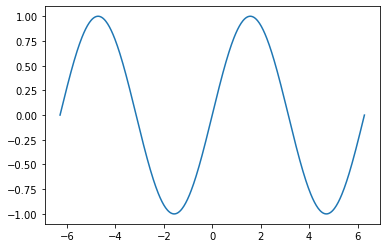

In [7]:
x = np.linspace(-2*np.pi, 2*np.pi, 500)
y = np.sin(x)

plt.plot(x, y)

### Q1.1: Complete the class in the cell below. (5 pts)

In [8]:
class ReLUMLP(nn.Module):
    def __init__(self, n):
        """Initialize ReLUMLP with `n` units in its hidden layer.
        """
        self.n = n
        
        super().__init__()
        self.nonlin = nn.ReLU() # oddly, we need to store this as an object!
        
        # create tensors for each set of parameters. remember to use requires_grad.
        # you also need to provide reasonable initial values!
        self.wt_in = torch.randn(n, 1, requires_grad=True)
        self.bias_in = torch.full((n, 1), 0.05, requires_grad=True)
        self.wt_out = torch.randn(1, n, requires_grad=True)

    def forward(self, x):
        """Given a vector `x`, compute `y-hat` for each entry.
        This can be accomplished in several ways, but pytorch is picky about how
        you do it!
        """
        x = x.view(1, x.size(0))
        x = torch.matmul(self.wt_in, x)
        x = x + self.bias_in
        x = self.nonlin(x)
        x = torch.matmul(self.wt_out, x)
        x = x.view(x.size(1))
        return x
    
    def parameters(self):
        """Tells the optimizer which parameters to optimize. Annoying that we 
        have to be explicit about this!
        """
        return [self.wt_in, self.bias_in, self.wt_out]

### Q 1.2: Complete the training function (2 pts)
Next, we need to define a function that will train our network. We provide most of this function here, but you will need to fill in the parts that compute model predictions (`y_hat`) and loss (`loss`).

In [9]:
def train_MLP(train_x, train_y, model, nepoch=1000, lr=1e-1):
    """Train an MLP `model` with training inputs `train_x` and outputs `train_y`
    for `nepoch` steps.
    """
    # Create the optimizer -- here we will use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Create the loss object
    loss_function = nn.MSELoss()
    
    # Make sure the inputs are torch tensors
    train_x_0 = torch.tensor(train_x)
    train_y_0 = torch.tensor(train_y)

    # We will store the losses to track our model's behavior
    losses = []
    
    for epoch in range(nepoch + 1):
        # print(model.parameters())
        # pytorch usually accumulates gradients over all backward passes.
        # Since we want to start afresh after every gradient update,
        # we explicitly reset gradients to 0.
        optimizer.zero_grad()
        
        # compute the model predictions using the forward method you defined earlier
        y_hat = model.forward(train_x_0)
        
        # compute the loss using the predictions, true values, and loss function
        loss = loss_function(y_hat, train_y_0)
        
        # compute gradients!
        loss.backward()
        
        # update the parameters using the optimizer's step method
        optimizer.step()
        
        # store & (maybe) display losses
        losses.append(loss.item())
        if not epoch%100:
            print("Loss @ {epoch}: ".format(epoch=epoch), losses[-1])
        
    return losses

### Q 1.3: Run the model and visualize the results! (2 pts)
_(this is where the fun begins)_

Fill in the code to create the model object, train the model, and plot the results. If this doesn't work well (i.e. final loss is greater than 0.1 or the function looks very weird) then you probably have a bug.

Loss @ 0:  338.61540222785857
Loss @ 100:  0.157459932382529
Loss @ 200:  0.14498108145888
Loss @ 300:  0.1320713513850415
Loss @ 400:  0.11661293444292424
Loss @ 500:  0.10069014498239878
Loss @ 600:  0.08506827702205413
Loss @ 700:  0.0718171490707193
Loss @ 800:  0.061861080208947046
Loss @ 900:  0.05372653158447604
Loss @ 1000:  0.045464505372490534
Loss @ 1100:  0.03658141204969944
Loss @ 1200:  0.02754754251867511
Loss @ 1300:  0.019336949079546032
Loss @ 1400:  0.012785719525563052
Loss @ 1500:  0.008186809123748282
Loss @ 1600:  0.005287689803273293
Loss @ 1700:  0.003616599146851109
Loss @ 1800:  0.00271589779585263
Loss @ 1900:  0.002257994827663378
Loss @ 2000:  0.002034167324829804
Loss @ 2100:  0.0019245202665121902
Loss @ 2200:  0.0018667427064146527
Loss @ 2300:  0.0018381390930593772
Loss @ 2400:  0.0018221139929538218
Loss @ 2500:  0.03082583220593209
Loss @ 2600:  0.0019174601216316062
Loss @ 2700:  0.0018500448665448358
Loss @ 2800:  0.0018257372493685133
Loss @ 2900

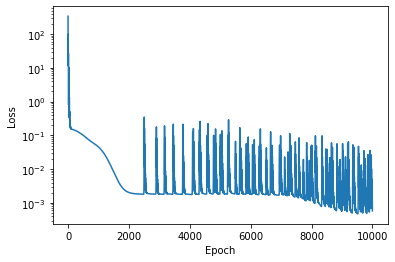

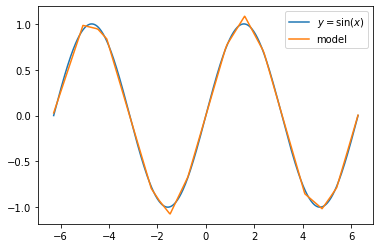

In [10]:
# first, create the model
# try with n=40 units in the hidden layer -- this should work well!
model = ReLUMLP(num_hidden_layers)

# then train it!
losses = train_MLP(x, y, model, 10000)

# plot the losses (semilogy is your friend)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.semilogy(range(len(losses)), losses)

# and plot the learned function
plt.figure()
predictions = model(torch.tensor(x)).detach().numpy()
plt.plot(x, y, label=r"$y=\sin(x)$")
plt.plot(x, predictions, label="model")
plt.legend()

### Q 1.4: Experimenting with learning rate (`lr`) and number of training epochs (`nepoch`) (3 pts)
Using the default settings should work reasonably well, but we can also adjust the learning rate and number of steps taken during learning.

Copy the model fitting & visualization code into the cell below, and then try adjusting the `lr` and `nepoch` parameters that can be passed to `train_MLP`.

Loss @ 0:  243.4287653915763
Loss @ 100:  0.07380455829119817
Loss @ 200:  0.040728225314914775
Loss @ 300:  0.027655614163848118
Loss @ 400:  0.017822552943936275
Loss @ 500:  0.010476353127399213


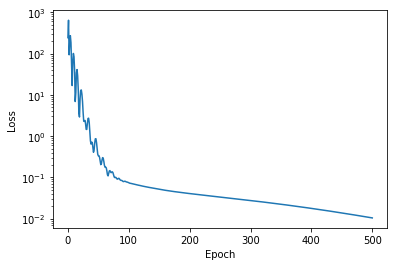

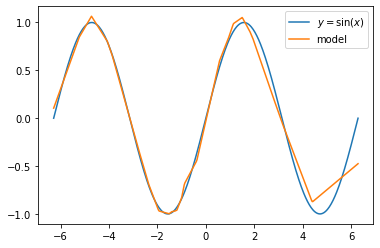

In [11]:
# first, create the model
# try with n=40 units in the hidden layer -- this should work well!
model = ReLUMLP(num_hidden_layers)

# then train it!
losses = train_MLP(x, y, model, 500, 3e-1)

# plot the losses (semilogy is your friend)
...
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.semilogy(range(len(losses)), losses)

# and plot the learned function
plt.figure()
predictions = model(torch.tensor(x)).detach().numpy()
plt.plot(x, y, label=r"$y=\sin(x)$")
plt.plot(x, predictions, label="model")
plt.legend()

(In the spaces provided, answer the following questions:)

* If you set the learning rate to be too large, what happens?

With too large of a learning rate, the loss is unable to decrease once it hits a certain value.
For example, with a learning rate of 10, the loss halts around 0.49.

* If you set the learning rate to be too small, what happens?

With too small of a learning rate, the changes in loss are very small and
require a large number of epochs to optimize well.

* Do the learning rate and number of epochs interact? i.e. if you change one, does it affect the best value for the other

Yes, with a large number of epochs, we can afford to have a slower learning rate that will
allow the function to optimize in smaller steps.

### Q 1.5: Simpler models using `nn.Sequential` (3 pts)
The function you wrote out above should work, but writing things so explicitly in pytorch is pretty annoying. You have to figure out how to handle multiple inputs, and also list out all the parameters. Ugh! Fortunately, there's a nicer interface that we can use!

To represent a _linear transformation_ of some input, you can use the `nn.Linear` object. Our function here should consist of three steps:
1. a linear transformation from 1 dimension ($x$) to $n$ dimensions, including a bias term,
2. a ReLU nonlinearity, and
3. a linear transformation from $n$ dimensions to 1 dimension ($y$) which does not include a bias term.

These steps can be rolled into an [`nn.Sequential` object](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). See those docs for an example, then write out the sequential version of your ReLU MLP in the following cell.

In [12]:
class BetterReLUMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.layers = nn.Sequential(
                        nn.Linear(1, n, bias=True),
                        nn.ReLU(),
                        nn.Linear(n, 1))

    def forward(self, x):
        # this is still slightly tricky. make sure that your output has only one dimension
        x = x.view(x.size(0), 1)
        x = self.layers(x)
        x = x.view(x.size(0))
        return x

### Q 1.6: Train your `BetterReLUMLP` (2 pts)
Now instantiate and train your new model! Note that `nn.Linear` expects a certain datatype, and your data will need to be in a specific (2D) shape for the training to work. You can use the numpy array method `astype` to convert your data to `np.float32`.

Loss @ 0:  1.3108098658125724
Loss @ 100:  0.06980320942915477
Loss @ 200:  0.030603567633530122
Loss @ 300:  0.0018540818804402587
Loss @ 400:  0.002231421119737475
Loss @ 500:  0.0008030326852488184
Loss @ 600:  0.024747128298653276
Loss @ 700:  0.00034673357591251066
Loss @ 800:  0.0004659764224051657
Loss @ 900:  0.0003724205768824773
Loss @ 1000:  0.0013105559192992913


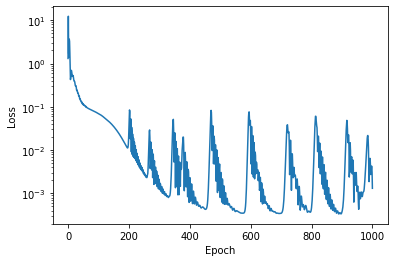

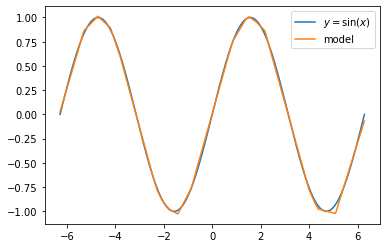

In [13]:
better_model = BetterReLUMLP(num_hidden_layers)

losses = train_MLP(x, y, better_model)

# Plot losses (semilogy!)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.semilogy(range(len(losses)), losses)

# and plot the learned function
plt.figure()
predictions = better_model(torch.tensor(x)).detach().numpy()
plt.plot(x, y, label=r"$y=\sin(x)$")
plt.plot(x, predictions, label="model")
plt.legend()

### Q 1.7: Switching from ReLU to a different nonlinearity (3 pts)
Now that you have things set up using `nn.Sequential`, it's trivial to try different network architectures, or swap out one nonlinearity for another.

For this problem, write a new class, `SigmoidMLP`, that uses a Sigmoid nonlinearity. Then try it out with a few different hidden layer sizes and answer the question in the cell below.

In [14]:
class SigmoidMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.layers = nn.Sequential(
                        nn.Linear(1, n, bias=True),
                        nn.Sigmoid(),
                        nn.Linear(n, 1))

    def forward(self, x):
        # this is still slightly tricky. make sure that your output has only one dimension
        x = x.view(x.size(0), 1)
        x = self.layers(x)
        x = x.view(x.size(0))
        return x

Loss @ 0:  0.48620959193259256
Loss @ 100:  0.06026644912991904
Loss @ 200:  0.016318213377224142
Loss @ 300:  0.003161521225606421
Loss @ 400:  0.012044715959241808
Loss @ 500:  0.000398167668747542
Loss @ 600:  0.00073159806576727
Loss @ 700:  0.0001665997206519931
Loss @ 800:  0.03898075663933295
Loss @ 900:  0.00013780731846463071
Loss @ 1000:  8.229676078370082e-05


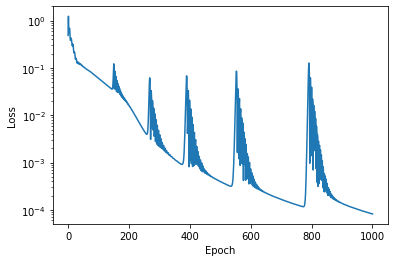

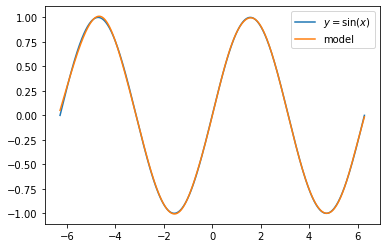

In [15]:
sigmoid_model = SigmoidMLP(num_hidden_layers)

losses = train_MLP(x, y, sigmoid_model)

# Plot losses (semilogy!)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.semilogy(range(len(losses)), losses)

# and plot the learned function
plt.figure()
predictions = sigmoid_model(torch.tensor(x)).detach().numpy()
plt.plot(x, y, label=r"$y=\sin(x)$")
plt.plot(x, predictions, label="model")
plt.legend()

In the spaces below, answer the following questions:

* How are the results of using a sigmoid different than using a ReLU?

The results of using the sigmoid function seem to be a lot better at approximating the sin wave than the ReLU nonlinearity. It seems that we do not see the extreme values that lead to vanishing gradient problems that the sigmoid function is susceptible to.

* Which seems better suited to this problem? Why?

The sigmoid seems better suited to this problem as the smoothness of it compared to the kinks in the ReLU function would serve to fit the sin function better without increasing the number of nodes in the hidden layers, and the resulting loss values agree with that.

## Problem 2. Examining gradients and non-linearities in MLPs (19 Points)

In this problem, we will consider a simple MLP of the form: $f(x) = w_{out}\cdot\sigma(w_{in}\cdot x)$ where $x, w_{out}, w_{in}$ are all scalars, and we assume biases to be 0.

In [16]:
# We will use a single training example to train the model.
x, y = 1., -1.

### Q 2.1: Implement the 1x1 MLP in pytorch below using <a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">torch.nn.Linear</a> (3 pts)

In [17]:
class TinySigmoidMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                        nn.Linear(1, 1, bias=False),
                        nn.Sigmoid(),
                        nn.Linear(1, 1, bias=False))

    def forward(self, x):
        x = self.layers(x)
        return x
    
sigmoid_model = TinySigmoidMLP()

### Q 2.2: Set the training `loss_function` to the mean squared error loss function in pytorch (1 pt)

In [18]:
loss_function = nn.MSELoss()

### Q 2.3: For this MLP, what is the analytical formula for the gradients? here, `L` refers to the MSE loss you initialized above (2 pts)
Pytorch automatically computes gradients through a computational graph, so you needn't actually code the gradient computation. But let's figure out what it is! For the derivative of the sigmoid, please just use $\sigma'(\cdot)$.

A. $\frac{\partial L}{\partial w_{out}}
= \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial w_{out}}
= \frac{1}{n} \sum \frac{d}{d \hat{y}} (y - \hat{y})^2 \cdot \sigma(w_{in}\cdot x)
= - \frac{2}{n} \sigma(w_{in}\cdot x) \cdot \sum (y - \hat{y})$

B. $\frac{\partial L}{\partial w_{in}} = - \frac{2}{n} w_{out} \cdot x \cdot \sigma'(w_{in}\cdot x) \cdot \sum (y - \hat{y})$

### Q 2.4: Finally, put all this together to write a training loop. Here, `w_in_init` and `w_out_init` refer to the initial value of the weights we will set (3 pts)

In [19]:
def train_TinyMLP(train_x, train_y, w_in_init, w_out_init, model, optimizer, nepoch):
    train_x_0 = torch.tensor([train_x])
    train_y_0 = torch.tensor([train_y])
    # Initialize the weights of the network manually.
    # the no_grad() below ensures that autograd doesn't know about this weight change!
    with torch.no_grad():
        # Set initial weights `w_in_init` and `w_out_init`.
        model.layers[0].weight[0][0] = w_in_init
        model.layers[2].weight[0][0] = w_out_init

    # We will store the predictions, losses etc. to track our model behavior.
    predictions = []
    losses = []
    in_gradients, out_gradients = [], []
    for epoch in range(nepoch):
        # PyTorch usually accumulates gradients over all backward passes.
        # Since we want to start afresh after every gradient update,
        # we explicitly reset gradients to 0.
        optimizer.zero_grad() 
        y_hat = model.forward(train_x_0)
        predictions.append(y_hat.item())
        loss = loss_function(y_hat, train_y_0)
        losses.append(loss.item())
        loss.backward()
        # Append gradients of each weight parameter.
        in_gradients.append(model.layers[0].weight.grad.item())
        out_gradients.append(model.layers[2].weight.grad.item())
        optimizer.step()
    return predictions, losses, in_gradients, out_gradients

In [20]:
# This is a simpler matplotlib helper function to visualize your model params.
def visualize(y, predictions, losses, in_gradients, out_gradients, nepoch):
    fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
    for ax, vals, title in zip(
            axs,
            [predictions, losses, in_gradients, out_gradients],
            ['$\hat{y}$', 'Loss', '$w_{in}$ gradient', '$w_{out}$ gradient']):
        ax.plot(range(len(vals)), vals, 'o-', lw=2, label=title)
        ax.set_ylabel(title, fontsize=14)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if title == '$\hat{y}$':
            ax.hlines(y, 0, nepoch, ls=':', color='k', lw=3, label='$y$')
            ax.legend(fontsize=14)
    return

### Q 2.5: Given the weight initializations below, run the model training, then answer the questions below (2 pts)


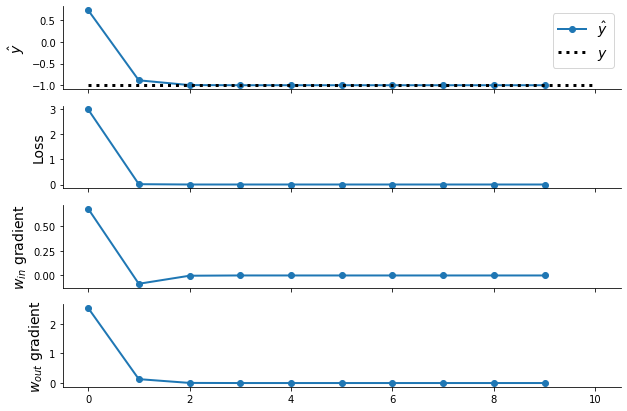

In [21]:
# For now, use the stochastic gradient descent optimizer.
optimizer = torch.optim.SGD(sigmoid_model.parameters(), lr=1)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.
nepoch = 10

# Now, let's try these weight initializations
w_in_init, w_out_init = 1, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, sigmoid_model, optimizer, nepoch)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

- Does the loss _converge_? What is the loss value at the end of training? Answer in the box below.

Yes, the loss converges by the end of training to almost 0.

- If the model doesn't work, briefly explain what could be wrong and how you would fix it.

HINT: The answers lie in the plots we are visualizing and Q 2.3. Pay close attention to how the value of each parameter changes over the course of training.

The model did work in this run, however a few errors I ran into that caused the model to break were incorrectly setting the initial weights so that the model started with wildly erroneous weights and also accidentally allowing the model to use biases in the Linear layers, which also did not end up converging and ruined the output.

### Q 2.6: Now train a new model using the given weight initialization, then answer the questions below (2 pts)

[3.9999999917553852, 3.9999999257984684, 3.999999859841553, 3.999999793884638, 3.9999997279277233, 3.9999996619708114, 3.999999596013899, 3.9999995300569817, 3.999999464100065, 3.999999398143149]


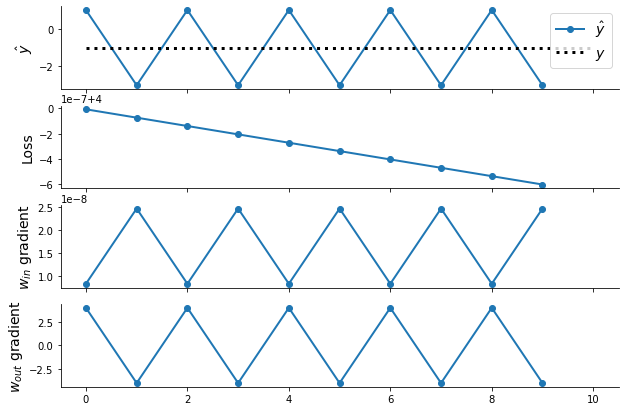

In [22]:
# For now, use the stochastic gradient descent optimizer.
optimizer = torch.optim.SGD(sigmoid_model.parameters(), lr=1)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.
nepoch = 10

w_in_init, w_out_init = 20, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, sigmoid_model, optimizer, nepoch)

print(losses)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

- Does the loss _converge_? What is the loss value at the end of training?

In this case, the loss does not converge and ends around -6 after training.

- If the model doesn't work, briefly explain what could be wrong and how you would fix it.

HINT: The answers lie in the plots we are visualizing and Q2.3. Pay close attention to how the value of each parameter changes over the course of training.

Looking at the plots of the weights, we see that they jump from epoch to epoch instead of slowly converging to a certain value. This is likely because the weights initial values were so far off from what they should be converging to that the gradient ended up being very high and causing the optimizer to step in very large increments. We could fix this by lowering the learning rate to prevent these big jumps and increasing the number of epochs to give the values more time to converge.

### Q 2.7: Implement the same MLP architecture but with ReLU nonlinearity instead of sigmoid (2 pts)

In [23]:
class TinyReLUMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc_in = nn.Linear(1, 1, bias=False)
        self.fc_out = nn.Linear(1, 1, bias=False)
        self.layers = nn.Sequential(self.fc_in, self.relu, self.fc_out)

    def forward(self, x):
        x = self.layers(x)
        return x
    
relu_model = TinyReLUMLP()

### Q 2.8: Train this model with the given weight initializations, then answer the question below (2 pts)

[441.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


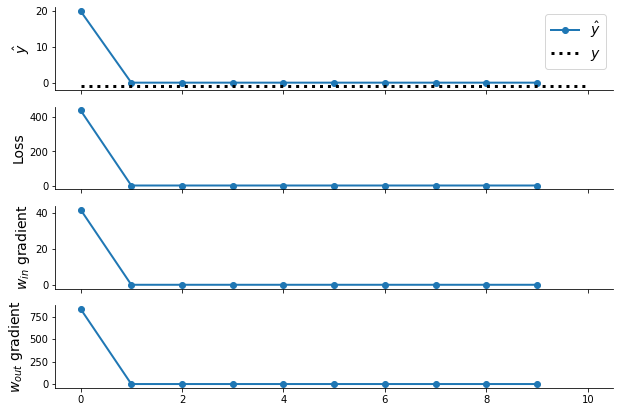

In [24]:
optimizer = torch.optim.SGD(relu_model.parameters(), lr=1)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.
nepoch = 10

w_in_init, w_out_init = 20, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, relu_model, optimizer, nepoch)

print(losses)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

You will find that it doesn't work. Why is that? Is the ReLU MLP plagued with the same issues as the sigmoid MLP? How can you fix it (without changing the weight initialization)? Answer below.

HINT: Think about what $\frac{\partial L}{\partial w_{out}}$ and $\frac{\partial L}{\partial w_{in}}$ would be for the ReLU MLP. The answer is in the size of updates we perform.

The partial derivatives for the ReLU MLP seem to be 0 because the values are negative, so we are hitting the negative side of the ReLU function where the derivative is 0. This causes the updates between each epoch to not change any weights or biases, so the losses don't decrease at all. This happens because the initial jump on the first epoch is very high and ends up overcorrecting into the negative side of the ReLU. We can fix this by decreasing the learning rate to keep the weights from changing too drastically and keeping everything on the positive side of the ReLU.

### Q 2.9: Fix how you fit the above ReLU model and run the `visualize` function (2 pts)

[441.0, 17.583597158400003, 0.7271664087225235, 0.03010264171159281, 0.0012461107367317053, 5.158225560624377e-05, 2.1352175828514557e-06, 8.83860150895605e-08, 3.6586839157496723e-09, 1.5144893092632823e-10]


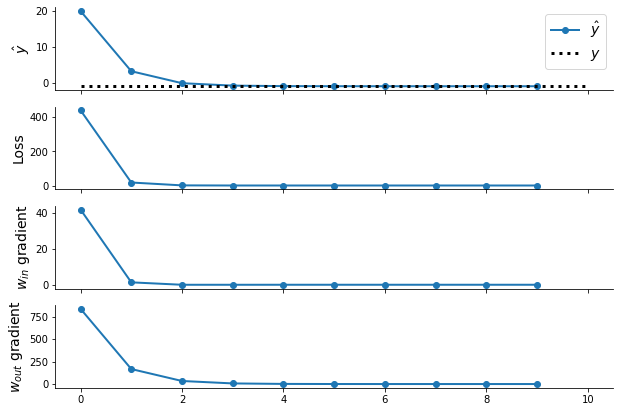

In [25]:
new_relu_model = TinyReLUMLP()

optimizer = torch.optim.SGD(new_relu_model.parameters(), lr=1e-3)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.
nepoch = 10

w_in_init, w_out_init = 20, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, new_relu_model, optimizer, nepoch)

print(losses)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

## Problem 3. Training MLPs on the Fashion MNIST dataset (22 Points)

In this problem, we will build MLPs on a freely available vision dataset, <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST</a>. This data has been increasingly gaining popularity as the "hello world!" of the ML community. It is simple enough to test new ideas on, and complex enough that our current models still have room for improvement. While you will find several blog-posts on MLPs for this dataset, we encourage you to work through this on your own- this is designed to familiarize you with pytorch and basic neural networks, for your class project and beyond.

Fashion MNIST consists of many 28x28 grayscale images belonging to 10 different classes of clothing. The task is to train a classifier that can predict the clothing class from the image.

In [26]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#### Let's load the data in pytorch!

All PyTorch datasets have a `tranform` argument to apply common transforms to the input data like normalizing, converting to a tensor etc.. Similarly, the `target_transform` argument can be applied to the output data (we will not use it here).

Read about torch datasets and dataloaders <a href="https://pytorch.org/vision/stable/datasets.html">here</a>!

In [27]:
from torchvision import datasets, transforms

save_dir = 'fashionMNIST_data'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.FashionMNIST(save_dir, download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashionMNIST_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: fashionMNIST_data
    Split: Test
    StandardTransform
Transform: ToTensor()


Each of these sets comprises of the image `data` and the clasification `targets`. The `targets` take a numerical value from 1-10 indicating which clothing class each image belongs to.

### Q 3.1 (2 pts)
- Print the classes in the train and test datasets.
- Visualize the first image in the training set.
- Print its classification label.

HINT:
`plt.imshow(image_array, cmap = 'Greys_r')` where `image_array` is a 28x28 array of the pixel values in the image.

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Ankle boot


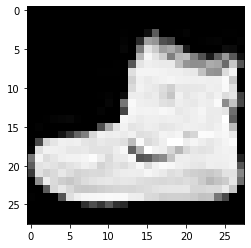

In [28]:
# print classes
classes = train_set.classes
print(classes)

# print label
img, label = train_set[0]
plt.imshow(img.squeeze(), cmap='Greys_r')
print(classes[label])

Since the original data does not have a validation set, let's create one by splitting the training set.

In [29]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
# ntotal = 1000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

### Q 3.2: Initialize the train, val and test dataloaders with the given `batch_size` (1 pt)

In [30]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size)

Each loader iterates over the data, yielding `batch_size` images and output targets per iteration.

In [31]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Q 3.3: Initialize an MLP with 3 fully-connected layers. You can add any non-linearity of your choice to the first two layers, and choose the layer widths as well (5 pts)

#### Define MLP

We have provided the skeleton class definition below. Complete it by specifying the layer objects in your MLP. Keep in mind that the input `x` is of shape (`batch_size`, 1, 28, 28). To feed this into the MLP, you will have to flatten it to shape (`batch_size`, 1x28x28). Additionally, the output should be of shape (`batch_size`, 10) as we have 10 classes.

You may find PyTorch functions like `reshape`, `view`, `flatten` etc. useful here.

In [32]:
class fashionMLP(nn.Module):
    def __init__(self):
        n1 = 160
        n2 = 40
        
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, n1),
            nn.GELU(),
            nn.Linear(n1, n2),
            nn.GELU(),
            nn.Linear(n2, 10, bias=False))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.layers(x)
        return x

Tip: An easy way to check if you got the dimensions right is to test your model on a single batch. Iteratively add each layer transformation to the input, and ensure the shape is right at each stage.

In [33]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
#     break
    model = fashionMLP()
    outputs = model(images)
    print(outputs.shape)
#     print(outputs)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


#### Loss and optimizer definitions
### Q 3.4: Define `criterion` to be the cross entropy loss function and use an optimizer of your choice (1 pt)

In [34]:
model = fashionMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=6e-3)

### Q 3.5 (2 pts)
Answer the following questions below.

- For classification problems, why is the softmax activation used on the final MLP output?

The softmax function allows us to take the values returned by the MLP and convert them into a probability distribution.

- Do you need to apply softmax here?

I thought softmax made sense as we want to ouput a probability distribution to get the most highly predicted output class, however when I added the softmax function to the layers of the model, it ended up with the model not changing at all and stabilizing at a high loss. I believe the softmax function has a quickly diminishing derivative and therefore is susceptible to the vanishing gradient problem. Because of this, the model does not train well with the softmax function applied at the end.

#### Model training and evaluation
### Q 3.6: Complete the training, validation and testing loops (3 pts)

In [35]:
from tqdm.notebook import tqdm

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.max(outputs, dim=1).indices # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

### Q 3.7: Understanding losses (2 pts)

What could the following scenarios suggest?
- Validation loss is _increasing_ continuously, while training loss continues to improve.
- Training loss  is _increasing_ continuously.

Answer in the box below.

If validation loss is increasing while training loss is improving, it most likely means we are overfitting to the training data. 
On the other hand, if the training loss is increasing, that likely means we have a bad network structure that may be having issues like the vanishing gradient problem or too many dead ReLU units, or it could be because of bad hyperparameters like the learning rate being set too high.

### Q 3.8: Train the network and report the final test accuracy of your model (1 pt)
Use the functions `train_network` and `test_network` defined above.

In [36]:
train_network(model, train_loader, val_loader, criterion, optimizer, 100)

acc, true, pred = test_network(model, test_loader, "Test")

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.50803
   Val loss: 0.46029

EPOCH 1
 Train loss: 0.39506
   Val loss: 0.39870

EPOCH 2
 Train loss: 0.36361
   Val loss: 0.37985

EPOCH 3
 Train loss: 0.34289
   Val loss: 0.35721

EPOCH 4
 Train loss: 0.32924
   Val loss: 0.37463

EPOCH 5
 Train loss: 0.31526
   Val loss: 0.36173

EPOCH 6
 Train loss: 0.30833
   Val loss: 0.33471

EPOCH 7
 Train loss: 0.29965
   Val loss: 0.34278

EPOCH 8
 Train loss: 0.29248
   Val loss: 0.36157

EPOCH 9
 Train loss: 0.29070
   Val loss: 0.36080

EPOCH 10
 Train loss: 0.28266
   Val loss: 0.34275

EPOCH 11
 Train loss: 0.27525
   Val loss: 0.37225

EPOCH 12
 Train loss: 0.26820
   Val loss: 0.34369

EPOCH 13
 Train loss: 0.26444
   Val loss: 0.36125

EPOCH 14
 Train loss: 0.26553
   Val loss: 0.35768

EPOCH 15
 Train loss: 0.25623
   Val loss: 0.34784

EPOCH 16
 Train loss: 0.24989
   Val loss: 0.35433

EPOCH 17
 Train loss: 0.24724
   Val loss: 0.39391

EPOCH 18
 Train loss: 0.24729
   Val loss: 0.37964

EPOCH 19
 Train loss: 

### Q 3.9: Which class did the model get wrong the most? Which class did it get right the most? (2 pts)

Hint: Compare the `true` and `pred` labels.

In [44]:
num_classes = len(classes)

totals = [0] * num_classes
right = [0] * num_classes
for i in range(len(true)):
    c = true[i]
    totals[c] += 1
    if true[i] == pred[i]:
        right[c] += 1

class_accuracies = {c: 0 for c in classes}
for i in range(num_classes):
    class_accuracies[classes[i]] = right[i] / totals[i]
    
sorted(class_accuracies.items(), key=lambda x:x[1])

[('Shirt', 0.699),
 ('Coat', 0.781),
 ('Pullover', 0.79),
 ('T-shirt/top', 0.825),
 ('Dress', 0.898),
 ('Ankle boot', 0.928),
 ('Sandal', 0.954),
 ('Bag', 0.959),
 ('Sneaker', 0.975),
 ('Trouser', 0.976)]

Looking at the dictionary of incorrect predictions, we can see that the model was incorrect the most on shirts, followed by coats and pullovers, while the model did the best on trousers, sneakers, and bags. The worse categories all seem to be more similar to each other, as all tops would have the same general image of a torso with arm sleeves, however boots, sneakers, trousers, and bags are all much more distinct.

### Q 3.10: Add any regularization method of your choice (or more than one!), and report the final test accuracy (3 pts)

In [46]:
class regularized_fashionMLP(nn.Module):
    def __init__(self):
        n1 = 160
        n2 = 40
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, n1),
            nn.Dropout(),
            nn.GELU(),
            nn.Linear(n1, n2),
            nn.Dropout(),
            nn.GELU(),
            nn.Linear(n2, 10, bias=False))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.layers(x)
        return x

In [47]:
# Instantiate the model, criterion, and optimizer
regmodel = regularized_fashionMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(regmodel.parameters(), lr=1e-3)

# Train the model
train_network(regmodel, train_loader, val_loader, criterion, optimizer, 100)

regmodel.eval() # disables some regularization methods for model testing

# Report test accuracy
acc, true, pred = test_network(regmodel, test_loader, "Test")

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.82796
   Val loss: 0.61864

EPOCH 1
 Train loss: 0.57490
   Val loss: 0.56755

EPOCH 2
 Train loss: 0.53045
   Val loss: 0.53787

EPOCH 3
 Train loss: 0.49602
   Val loss: 0.50233

EPOCH 4
 Train loss: 0.48570
   Val loss: 0.48110

EPOCH 5
 Train loss: 0.46740
   Val loss: 0.49751

EPOCH 6
 Train loss: 0.45666
   Val loss: 0.48251

EPOCH 7
 Train loss: 0.44842
   Val loss: 0.47275

EPOCH 8
 Train loss: 0.44067
   Val loss: 0.47873

EPOCH 9
 Train loss: 0.43298
   Val loss: 0.46460

EPOCH 10
 Train loss: 0.42683
   Val loss: 0.46746

EPOCH 11
 Train loss: 0.41870
   Val loss: 0.45715

EPOCH 12
 Train loss: 0.41697
   Val loss: 0.47215

EPOCH 13
 Train loss: 0.41320
   Val loss: 0.45964

EPOCH 14
 Train loss: 0.41164
   Val loss: 0.45340

EPOCH 15
 Train loss: 0.40193
   Val loss: 0.45441

EPOCH 16
 Train loss: 0.40234
   Val loss: 0.45493

EPOCH 17
 Train loss: 0.39936
   Val loss: 0.45951

EPOCH 18
 Train loss: 0.39446
   Val loss: 0.46838

EPOCH 19
 Train loss: 